In [155]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import normaltest

In [156]:
test='https://raw.githubusercontent.com/Saul-Ochoa/Time-Series/main/Sarima/test%20(1).csv'
train='https://raw.githubusercontent.com/Saul-Ochoa/Time-Series/main/Sarima/train.csv'
train=pd.read_csv(train, sep=',')
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")
train_df = train[train['store']==1]
train_df = train_df[train['item']==1]
train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month
train_df['day'] = train['date'].dt.dayofyear
train_df['weekday'] = train['date'].dt.weekday
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)

# **Arima**

In [157]:
# Ya no se usa el disp
arima_mod6 = sm.tsa.ARIMA(train_df.sales, order=(6, 1, 0)).fit()
print(arima_mod6.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.679
Date:                Thu, 07 Sep 2023   AIC                          11209.359
Time:                        21:52:40   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

## **Residuos Arima**

NormaltestResult(statistic=16.742690145385367, pvalue=0.00023140408899260736)


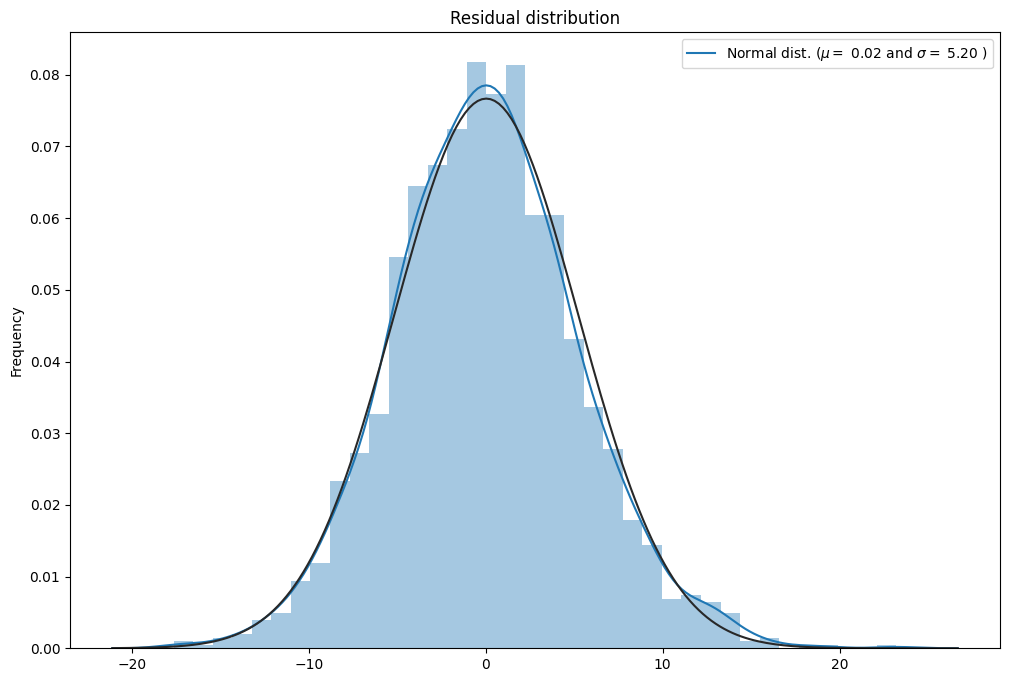

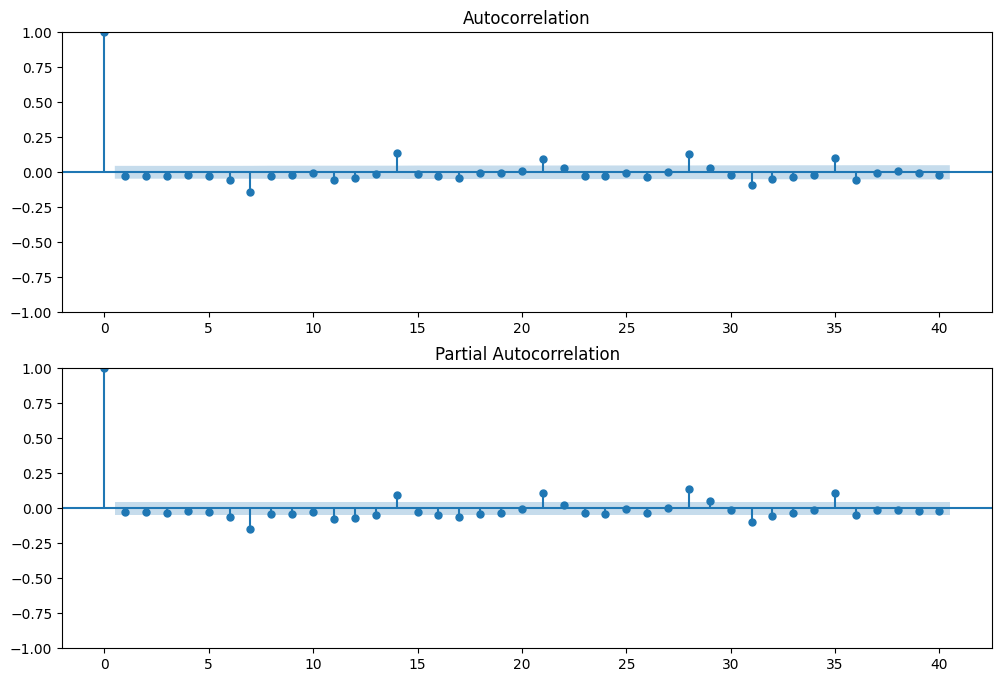

In [158]:
resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

# **Sarima**

In [159]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(train_df.sales, trend='n', order=(6,1,0)).fit()
print(sarima_mod6.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Thu, 07 Sep 2023   AIC                          11209.359
Time:                        21:52:41   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

NormaltestResult(statistic=16.742690145385367, pvalue=0.00023140408899260736)


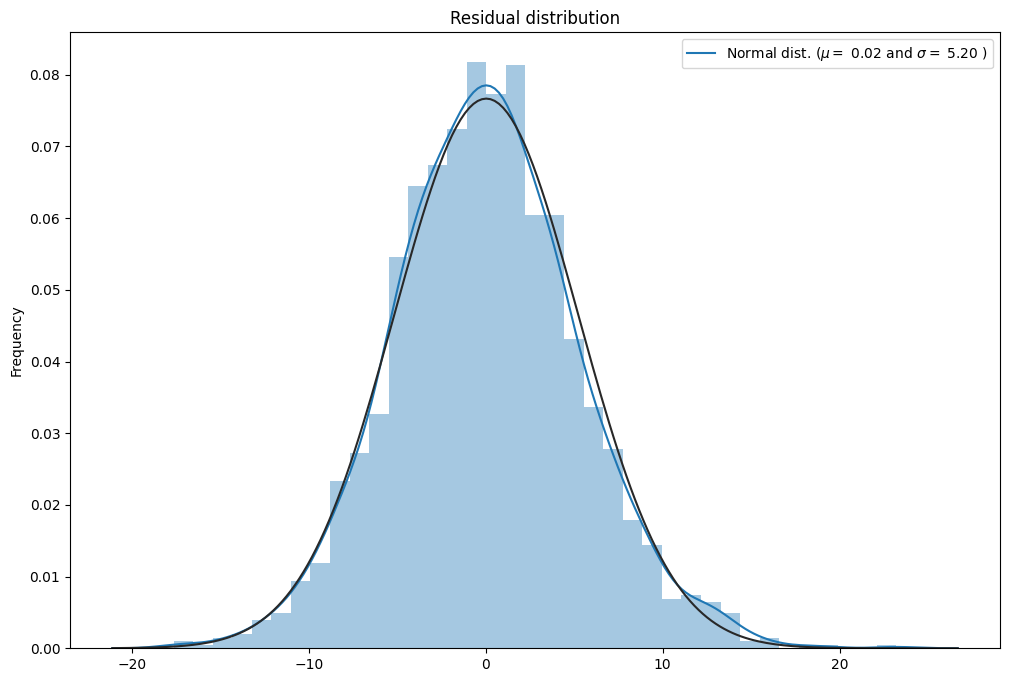

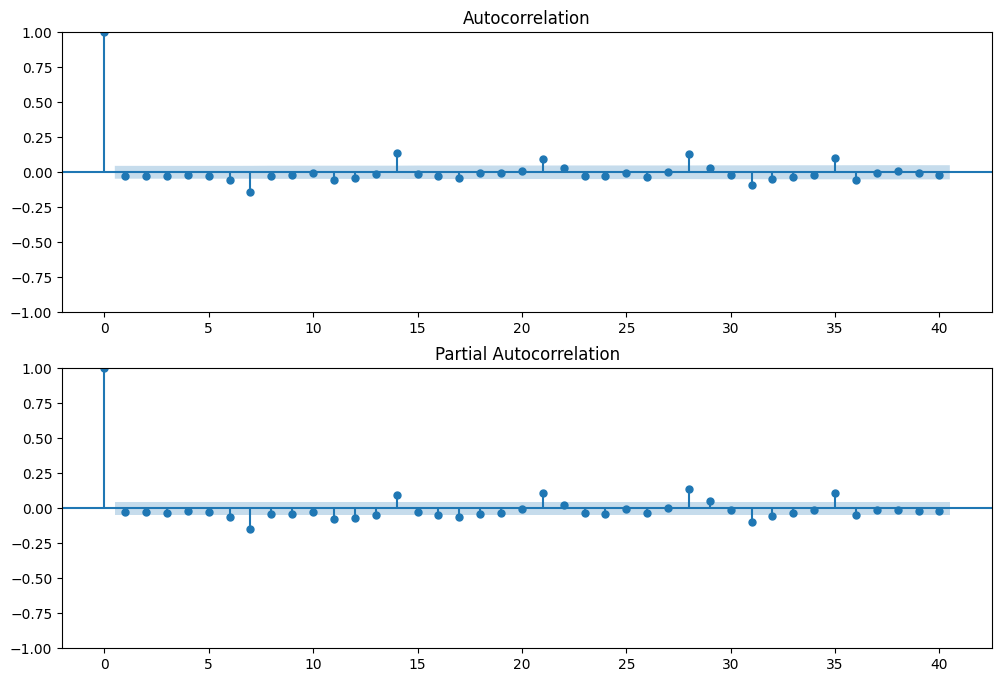

In [160]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

# **Make Prediction**

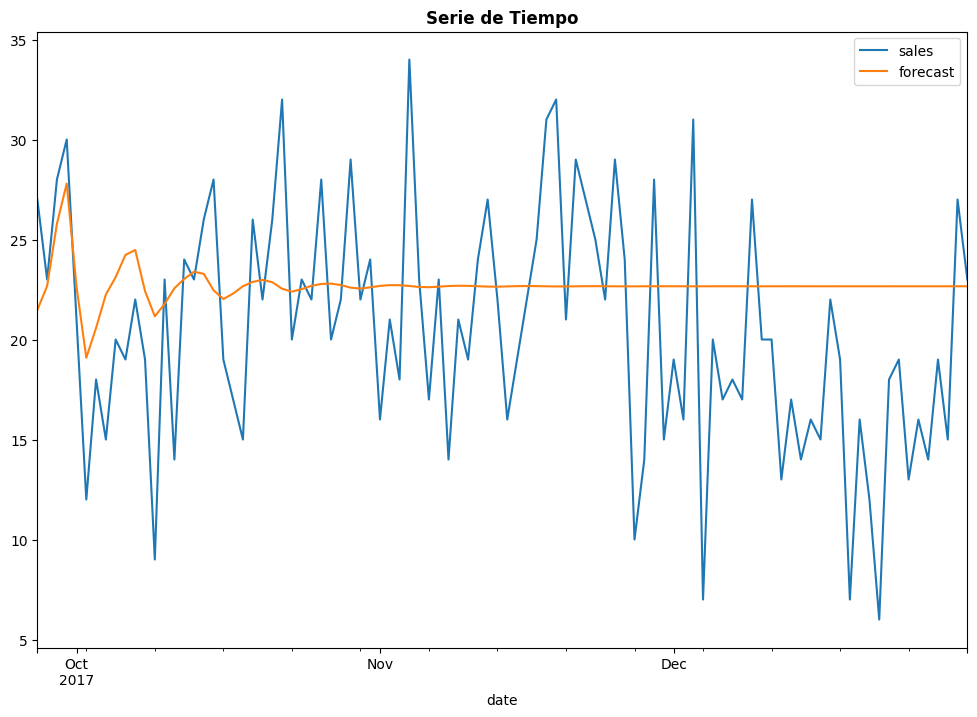

In [161]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))
plt.title('Serie de Tiempo',fontsize=12,weight='bold')
plt.show()

In [162]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [163]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 33.01 % 
SMAPE: 25.07 %


In [164]:
holiday='https://raw.githubusercontent.com/uWaterloo/Datasets/master/Holidays/holidays.csv'
holiday=pd.read_csv(holiday,sep=',')
holiday

,date,holiday
0,2012-01-02,New Year's Day
1,2012-02-20,Family Day
2,2012-04-06,Good Friday
3,2012-05-21,Victoria Day
4,2012-07-02,Canada Day
...,...,...
193,2025-12-25,Christmas Day
194,2025-12-26,Boxing Day
195,2025-12-29,Additional Day
196,2025-12-30,Additional Day


In [165]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     198 non-null    object
 1   holiday  198 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [166]:
holiday['date'] = pd.to_datetime(holiday['date'], yearfirst = True, format = '%Y-%m-%d')
holiday.head()

,date,holiday
0,2012-01-02,New Year's Day
1,2012-02-20,Family Day
2,2012-04-06,Good Friday
3,2012-05-21,Victoria Day
4,2012-07-02,Canada Day


In [167]:
train_df = train_df.merge(holiday, how='left', on='date')
train_df['holiday_bool'] = pd.notnull(train_df['holiday']).astype(int)
train_df = pd.get_dummies(train_df, columns = ['month','holiday','weekday'] , prefix = ['month','holiday','weekday'])

In [173]:
train_df.columns

Index(['store', 'item', 'sales', 'year', 'day', 'forecast', 'holiday_bool',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'holiday_Additional Day', 'holiday_Boxing Day', 'holiday_Canada Day',
       'holiday_Christmas', 'holiday_Christmas Day', 'holiday_Civic Holiday',
       'holiday_Family Day', 'holiday_Good Friday', 'holiday_Labour Day',
       'holiday_New Year's Day', 'holiday_Thanksgiving',
       'holiday_Victoria Day', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [174]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   store                   1826 non-null   int64  
 1   item                    1826 non-null   int64  
 2   sales                   1826 non-null   float64
 3   year                    1826 non-null   int32  
 4   day                     1826 non-null   int32  
 5   forecast                96 non-null     float64
 6   holiday_bool            1826 non-null   int32  
 7   month_1                 1826 non-null   bool   
 8   month_2                 1826 non-null   bool   
 9   month_3                 1826 non-null   bool   
 10  month_4                 1826 non-null   bool   
 11  month_5                 1826 non-null   bool   
 12  month_6                 1826 non-null   bool   
 13  month_7                 1826 non-null   bool   
 14  month_8               

In [175]:
# Convierte todas las columnas binarias en valores numéricos 1 y 0
train_df[['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'holiday_Additional Day']] = train_df[['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'holiday_Additional Day']].astype(int)
train_df.head()

,store,item,sales,year,day,forecast,holiday_bool,month_1,month_2,month_3,...,holiday_New Year's Day,holiday_Thanksgiving,holiday_Victoria Day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,13.0,2013,1,NaN,1,1,0,0,...,True,False,False,False,True,False,False,False,False,False
2013-01-02,1,1,11.0,2013,2,NaN,0,1,0,0,...,False,False,False,False,False,True,False,False,False,False
2013-01-03,1,1,14.0,2013,3,NaN,0,1,0,0,...,False,False,False,False,False,False,True,False,False,False
2013-01-04,1,1,13.0,2013,4,NaN,0,1,0,0,...,False,False,False,False,False,False,False,True,False,False
2013-01-05,1,1,10.0,2013,5,NaN,0,1,0,0,...,False,False,False,False,False,False,False,False,True,False


In [179]:
columns_to_convert = ['holiday_Boxing Day', 'holiday_Canada Day', 'holiday_Christmas',
   'holiday_Christmas Day', 'holiday_Civic Holiday', 'holiday_Family Day',
   'holiday_Good Friday', 'holiday_Labour Day', "holiday_New Year's Day",
   'holiday_Thanksgiving', 'holiday_Victoria Day', 'weekday_0',
   'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
   'weekday_6']

# Convierte todas las columnas binarias en valores numéricos 1 y 0
train_df[columns_to_convert] = train_df[columns_to_convert].astype(int)


In [181]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   store                   1826 non-null   int64  
 1   item                    1826 non-null   int64  
 2   sales                   1826 non-null   float64
 3   year                    1826 non-null   int32  
 4   day                     1826 non-null   int32  
 5   forecast                96 non-null     float64
 6   holiday_bool            1826 non-null   int32  
 7   month_1                 1826 non-null   int32  
 8   month_2                 1826 non-null   int32  
 9   month_3                 1826 non-null   int32  
 10  month_4                 1826 non-null   int32  
 11  month_5                 1826 non-null   int32  
 12  month_6                 1826 non-null   int32  
 13  month_7                 1826 non-null   int32  
 14  month_8               

In [192]:
train_df.columns

Index(['store', 'item', 'sales', 'year', 'day', 'forecast', 'holiday_bool',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'holiday_Additional Day', 'holiday_Boxing Day', 'holiday_Canada Day',
       'holiday_Christmas', 'holiday_Christmas Day', 'holiday_Civic Holiday',
       'holiday_Family Day', 'holiday_Good Friday', 'holiday_Labour Day',
       'holiday_New Year's Day', 'holiday_Thanksgiving',
       'holiday_Victoria Day', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [195]:
ext_var_list=['year', 'day','holiday_bool',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'holiday_Additional Day', 'holiday_Boxing Day', 'holiday_Canada Day',
       'holiday_Christmas', 'holiday_Christmas Day', 'holiday_Civic Holiday',
       'holiday_Family Day', 'holiday_Good Friday', 'holiday_Labour Day',
       "holiday_New Year's Day", 'holiday_Thanksgiving',
       'holiday_Victoria Day', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']

In [196]:
exog_data = train_df[ext_var_list]
exog_data.head()

,year,day,holiday_bool,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,holiday_New Year's Day,holiday_Thanksgiving,holiday_Victoria Day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2013,1,1,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2013-01-02,2013,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-03,2013,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-04,2013,4,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-05,2013,5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [197]:
train_df.head()

,store,item,sales,year,day,forecast,holiday_bool,month_1,month_2,month_3,...,holiday_New Year's Day,holiday_Thanksgiving,holiday_Victoria Day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,13.0,2013,1,NaN,1,1,0,0,...,1,0,0,0,1,0,0,0,0,0
2013-01-02,1,1,11.0,2013,2,NaN,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-03,1,1,14.0,2013,3,NaN,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-04,1,1,13.0,2013,4,NaN,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-05,1,1,10.0,2013,5,NaN,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [198]:
start_index = '2017-10-01'
end_index = '2017-12-31'
sarimax_mod6 = sm.tsa.statespace.SARIMAX(endog = train_df.sales[:start_index],
                                        exog = exog_data[:start_index],  
                                        trend='n', order=(6,1,0), seasonal_order=(0,1,1,7)).fit()
print(sarimax_mod6.summary())


                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                 1735
Model:             SARIMAX(6, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -5135.137
Date:                             Thu, 07 Sep 2023   AIC                          10354.274
Time:                                     22:11:25   BIC                          10583.348
Sample:                                 01-01-2013   HQIC                         10439.011
                                      - 10-01-2017                                         
Covariance Type:                               opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
year                    -282.4884    104.924     -2.692      0.007    -488.135    

In [200]:
start_index = '2017-10-01'
end_index = '2017-12-30'
end_index1 = '2017-12-31'
sarimax_mod6.forecast(steps = 91,exog = exog_data[start_index:end_index])

2017-10-02    16.707444
2017-10-03    20.240426
2017-10-04    21.975637
2017-10-05    21.813879
2017-10-06    23.562933
                ...    
2017-12-27    14.437924
2017-12-28    18.940460
2017-12-29    20.677707
2017-12-30    22.424493
2017-12-31    20.531349
Freq: D, Name: predicted_mean, Length: 91, dtype: float64

<Axes: xlabel='date'>

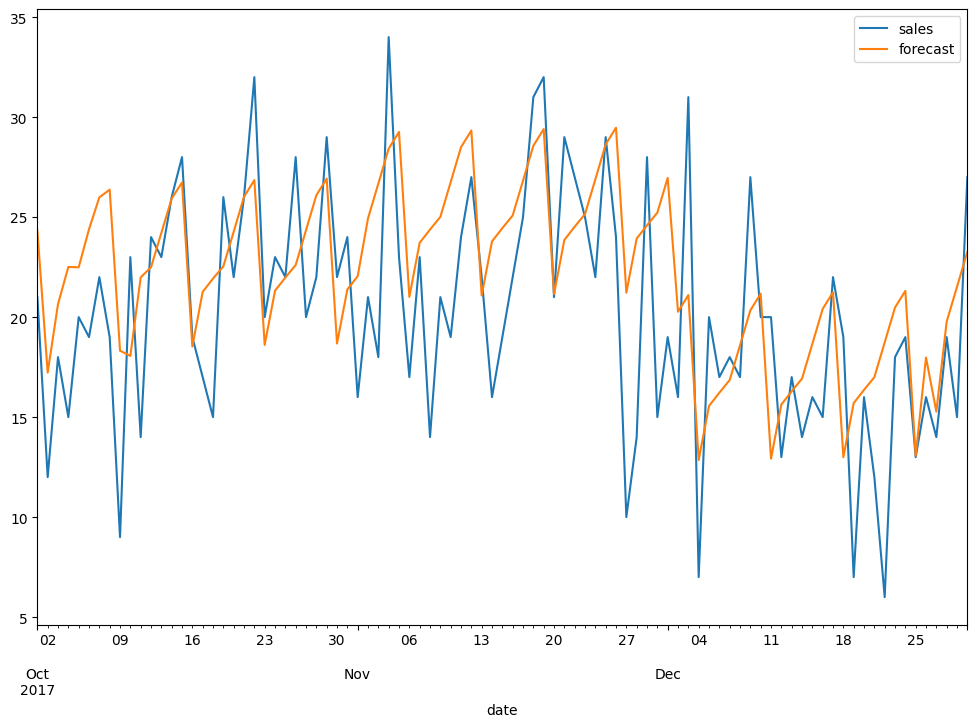

In [201]:
train_df['forecast'] = sarimax_mod6.predict(start = pd.to_datetime(start_index), end= pd.to_datetime(end_index1),
                                            exog = exog_data[start_index:end_index], 
                                            dynamic= True)  

train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [202]:
smape_kun(train_df[start_index:end_index]['sales'],train_df[start_index:end_index]['forecast'])

MAPE: 25.82 % 
SMAPE: 21.18 %
